# Домашнее задание 7. Детектирование объектов

In [8]:
import numpy as np
import os
import shutil
from pathlib import Path
from PIL import Image

#pip install imageai
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection

## Задание

1. Попробуйте обучить нейронную сеть YOLOv3 из ImageAI на любом датасете. Можете взять один из этих наборов данных:

    https://www.kaggle.com/brendan45774/chess-piece-dectection/
    
    https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection
    
    https://www.kaggle.com/sshikamaru/car-object-detection
    
    https://www.kaggle.com/lplenka/coco-car-damage-detection-dataset

2*. Сделайте краткий обзор какой-нибудь научной работы, посвященной алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

## План работы

[0. Загрузка и обзор данных](#section_0)

[1. Предобработка данных](#section_1)

[2. Обучение модели детекции](#section_2)

[3. Оценка модели детекции](#section_3)

[4. Детектирование объекта](#section_4)

[5*. Обзор научной работы, посвященной модели  составной магистральной сети CBNet для обнаружения объектов](#section_5)

## 0. Загрузка и обзор данных<a id='section_0'></a>

Используем набор https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

In [9]:
#созданы две папки train и validation, 
#в каждой из которых есть папки images и annotations
root_annots_train_path = 'datasets/detection/train/annotations/'
root_images_train_path = 'datasets/detection/train/images/'

root_annots_test_path = 'datasets/detection/validation/annotations/'
root_images_test_path = 'datasets/detection/validation/images/'

flist_images_train = os.listdir(root_images_train_path)
flist_annots_train = os.listdir(root_annots_train_path)

flist_images_test = os.listdir(root_images_test_path)
flist_annots_test = os.listdir(root_annots_test_path)

n_imgs_train = len(flist_images_train)
n_imgs_test = len(flist_images_test)

print('Количество изображений в train: ', n_imgs_train)
print('Количество изображений в test: ', n_imgs_test)

Количество изображений в train:  240
Количество изображений в test:  60


apple_10.jpg


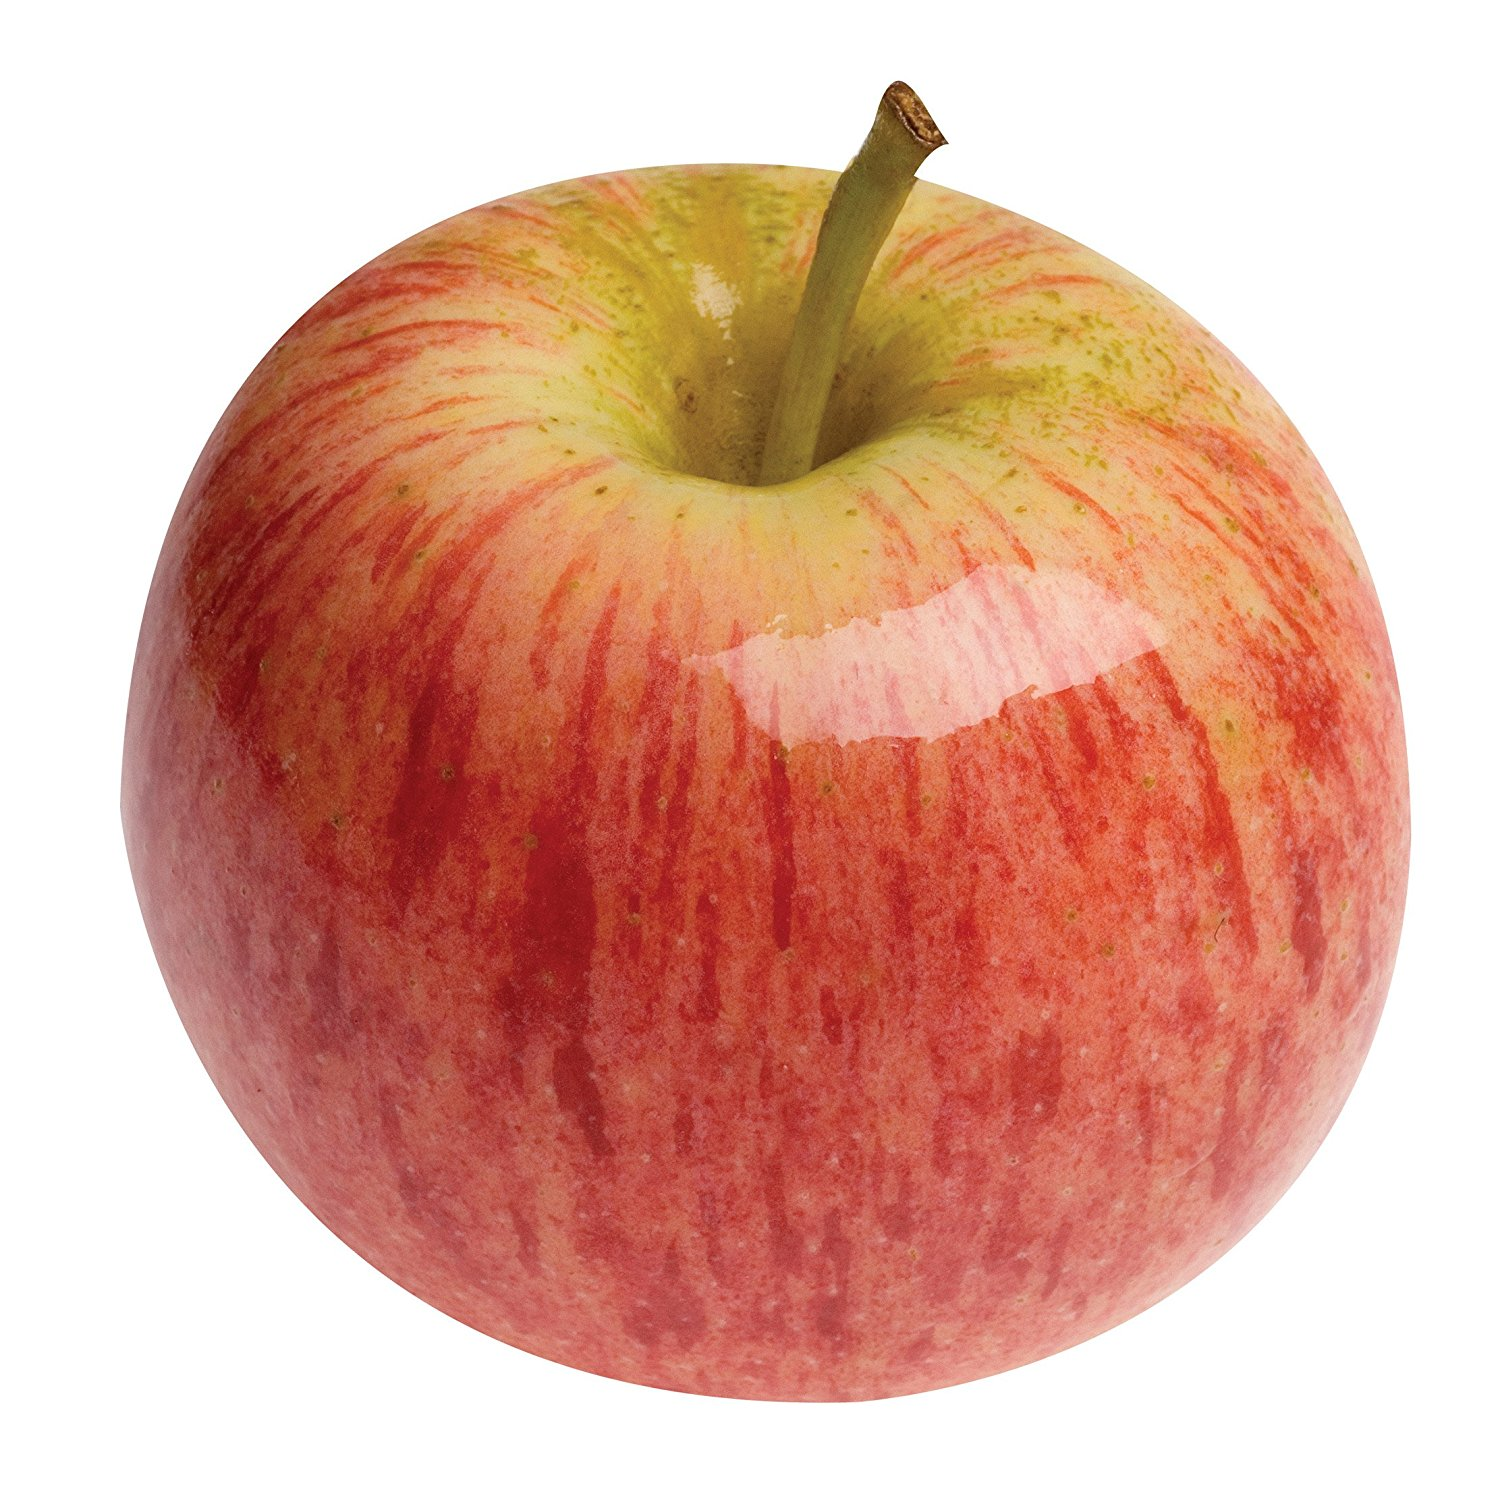

In [10]:
print(flist_images_train[1])
Image.open(root_images_train_path + flist_images_train[1])

In [11]:
with open(root_annots_train_path + flist_annots_train[1], 'r') as f:
    print(f.read())

<annotation>
	<folder>train</folder>
	<filename>apple_10.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_10.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1500</width>
		<height>1500</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>56</xmin>
			<ymin>99</ymin>
			<xmax>1413</xmax>
			<ymax>1419</ymax>
		</bndbox>
	</object>
</annotation>



## 1. Предобработка данных<a id='section_1'></a>

In [12]:
#Функция  исправления нулевых значений width и height в аннотациях
def editXML(file, folder):
    
    my_file = open(file, 'r')
    string = my_file.read()
    
    width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
    height = string[string.find('<height>')+len('<height>') : string.find('</height>')]
    
    if width == '0' or height == '0':
        
        folder = folder
        filename = string[string.find('<filename>')+len('<filename>') : string.find('</filename>')]
        path_img = f'datasets/detection/{folder}/images/{filename}'
        
        im = Image.open(path_img)
        (width_im, height_im) = im.size

        string1 = string.replace('<width>0</width>', f'<width>{width_im}</width>')
        string2 = string1.replace('<height>0</height>', f'<height>{height_im}</height>')
        string2

        f = open('newfile.xml','w') 
        f.write(string2)  
        f.close()

        return 'newfile.xml'
    
    else:
        return file

In [13]:
# создание директорий для сохранение предобработанных данных
os.makedirs('datasets/detection/imageai/data/train/images', exist_ok=True)
os.makedirs('datasets/detection/imageai/data/train/annotations', exist_ok=True)

os.makedirs('datasets/detection/imageai/data/validation/images', exist_ok=True)
os.makedirs('datasets/detection/imageai/data/validation/annotations', exist_ok=True)

In [14]:
#предобработка и сохранение предобработанных данных
for i in range(n_imgs_train):
    shutil.copy(root_images_train_path + flist_images_train[i], 'datasets/detection/imageai/data/train/images/' + flist_images_train[i])
    annot_train_new = editXML(root_annots_train_path + flist_annots_train[i], 'train')
    shutil.copy(annot_train_new, 'datasets/detection/imageai/data/train/annotations/' + flist_annots_train[i])
    
for i in range(n_imgs_test):
    shutil.copy(root_images_test_path + flist_images_test[i], 'datasets/detection/imageai/data/validation/images/' + flist_images_test[i])
    annot_test_new = editXML(root_annots_test_path + flist_annots_test[i], 'validation')
    shutil.copy(annot_test_new, 'datasets/detection/imageai/data/validation/annotations/' + flist_annots_test[i])

In [15]:
print(len(list(Path('datasets/detection/imageai/data/train/annotations/').glob('*.xml'))))
print(len(list(Path('datasets/detection/imageai/data/validation/annotations/').glob('*.xml'))))

240
60


## 2. Обучение модели детекции<a id='section_2'></a>

In [16]:
#имена объектов в наборе
classes = np.array(["apple", "banana", "orange"])

In [17]:
trainer = DetectionModelTrainer() #импортируем класс обучения модели
trainer.setModelTypeAsYOLOv3() #определяем тип сети
trainer.setDataDirectory(data_directory="datasets/detection/imageai/data/") #путь к набору данных
#настраиваем обучение модели
trainer.setTrainConfig(object_names_array=classes,
                       batch_size=8, #размер пакета для обучения
                       num_experiments=10, #количество эпох
                       #предварительно обученная модель
                       train_from_pretrained_model="datasets/detection/models/pretrained-yolov3.h5")

#в процессе обучения создается imaginea/data/json/detection_config.json 
#после каждой эпохи модель сохраняется в imaginea/data/models
trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.80
Anchor Boxes generated.
Detection configuration saved in  datasets/detection/imageai/data/json\detection_config.json
Evaluating over 60 samples taken from datasets/detection/imageai/data/validation
Training over 240 samples  given at datasets/detection/imageai/data/train
Training on: 	['apple', 'banana', 'orange']
Training with Batch Size:  8
Number of Training Samples:  240
Number of Validation Samples:  60
Number of Experiments:  10
Training with transfer learning from pretrained Model


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
240/240 [==============================] - 4770s 20s/step - loss: 96.3501 - yolo_layer_loss: 13.4000 - yolo_layer_1_loss: 24.7536 - yolo_layer_2_loss: 46.6223 - val_loss: 45.3894 - val_yolo_layer_loss: 6.6993 - val_yolo_layer_1_loss: 9.7337 - val_yolo_layer_2_loss: 17.4639
Epoch 2/10
240/240 [==============================] - 7123s 30s/step - loss: 45.4224 - yolo_layer_loss: 7.1760 - yolo_layer_1_loss: 10.3961 - yolo_layer_2_loss: 16.4609 - val_loss: 43.8967 - val_yolo_layer_loss: 8.1912 - val_yolo_layer_1_loss: 9.4214 - val_yolo_layer_2_loss: 15.4315
Epoch 3/10
240/240 [==============================] - 8007s 33s/step - loss: 43.2029 - yolo_layer_loss: 7.9765 - yolo_layer_1_loss: 10.1977 - yolo_layer_2_loss: 14.3628 - val_loss: 42.9503 - val_yolo_layer_loss: 8.0547 - val_yolo_layer_1_loss: 9.0672 - val_yolo_layer_2_loss: 15.6386
Epoch 4/10
240/240 [==============================] - 7580s 32s/step - loss: 40.1375 - yolo_layer_loss: 6.0099 - yolo_layer_1_loss: 8.9435 - yolo_l

## 3. Оценка модели детекции<a id='section_3'></a>

In [27]:
# оценка всех сохраненнных моделей
model_path_all = 'datasets/detection/imageai/data/models/'
model_path_all

'datasets/detection/imageai/data/models/'

In [28]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3() #тип сети
trainer.setDataDirectory(data_directory="datasets/detection/imageai/data/") #путь к данным
metrics = trainer.evaluateModel(model_path=model_path_all, #модель для оценки
                                #файл процесса обучения
                                json_path="datasets/detection/imageai/data/json/detection_config.json",
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 60 samples taken from datasets/detection/imageai/data/validation
Training over 240 samples  given at datasets/detection/imageai/data/train
Model File:  datasets/detection/imageai/data/models/detection_model-ex-001--loss-0065.898.h5 

Evaluation samples:  60
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
apple: 0.0599
banana: 0.0250
orange: 0.0000
mAP: 0.0283
Model File:  datasets/detection/imageai/data/models/detection_model-ex-002--loss-0043.922.h5 

Evaluation samples:  60
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
apple: 0.0070
banana: 0.0573
orange: 0.0000
mAP: 0.0214
Model File:  datasets/detection/imageai/data/models/detection_model-ex-003--loss-0041.991.h5 

Evaluation samples:  60
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
apple: 0.0375
banana: 0.2700
orange: 0.0000
mAP: 0.1025
Model File:  datasets/detection/imageai/data/mo

In [29]:
# оценка одной (лучшей) сохраненной модели
model_path = 'datasets/detection/imageai/data/models/detection_model-ex-006--loss-0037.429.h5'
model_path

'datasets/detection/imageai/data/models/detection_model-ex-006--loss-0037.429.h5'

In [30]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3() #тип сети
trainer.setDataDirectory(data_directory="datasets/detection/imageai/data/") #путь к данным
metrics = trainer.evaluateModel(model_path=model_path, #модель для оценки
                                #файл процесса обучения
                                json_path="datasets/detection/imageai/data/json/detection_config.json",
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 60 samples taken from datasets/detection/imageai/data/validation
Training over 240 samples  given at datasets/detection/imageai/data/train
Model File:  datasets/detection/imageai/data/models/detection_model-ex-006--loss-0037.429.h5 

Evaluation samples:  60
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
apple: 0.2393
banana: 0.2049
orange: 0.1458
mAP: 0.1967


## 4. Детектирование объекта<a id='section_4'></a>

In [41]:
#лучшая модель
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_path)
detector.setJsonPath("datasets/detection/imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=50,
                                             input_image="datasets/detection/imageai/data/validation/images/apple_86.jpg",
                                             output_image_path="datasets/detection/imageai/data/detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

apple  :  56.533777713775635  :  [251, 141, 313, 200]
apple  :  52.356088161468506  :  [36, 147, 102, 205]
apple  :  64.75175023078918  :  [328, 147, 383, 206]


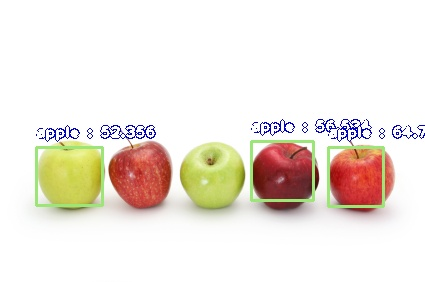

In [42]:
Image.open('datasets/detection/imageai/data/detected.jpg')

## 5*. Обзор научной работы, посвященной модели  составной магистральной сети CBNet для обнаружения объектов<a id='section_5'></a>

### CBNet: Новая архитектура составной магистральной сети для обнаружения объектов

*Оригинальная статья:* https://arxiv.org/pdf/1909.03625.pdf

![jupyter](datasets/detection/screenshots/screen1.png)

Composite Backbone Network (CBNet) состоит из нескольких магистралей (вспомогательные и ведущая) с одинаковой сетевой структурой и составных соединений между этими магистралями. Составная магистральая сеть CBNet итеративно передает выходные признаки предыдущей магистрали как часть входных признаков в последующую магистраль поэтапно и использует признаки последней магистрали для решения задачи детекции.

**Новизна модели.** Признаки, извлеченные CBNet для обнаружения объектов, сочетают высоко- и низкоуровневые признаки предыдущих магистралей, следовательно, повышают качество решения задачи детекции. Стоит отметить, что нет необходимости предобучать CBNet для обучения интегрированного с ним детектора. Вместо этого нужно только инициализировать каждую магистраль CBNet с помощью предобученной модели, такой как ResNet и ResNeXt. 

### Архитектура CBNet

Архитектура CBNet состоит из $K$ идентичных магистралей ($K \geq 2 $). Магистрали $B_1$, $B_2$, $\ldots, B_{K−1}$ называются вспомогательными, магистраль $B_K$ – ведущей. 

Каждая магистраль состоит из $L$ ступеней (обычно $L = 5$), каждая из которых содержит несколько сверточных слоев с картами признаков одинакового размера. $l$-я ступень магистрали реализует нелинейное преобразование $F^l$, $l\in L$.

Выходы каждой ступени вспомогательных магистралей $B_1, B_2, \ldots, B_{K−1}$ перенаправляются в соседнюю магистраль (слева направо). Более того, $B_1, B_2, \ldots, B_{K−1}$ в CBNet могут использовать различные архитектуры, такие как ResNet или ResNeXt, и могут быть инициализированы непосредственно из предобученной модели. Выход ведущей магистрали принимается в качестве входных данных детектора.


### Cтили CBNet
В зависимости от составных соединений между соседними магистралями, различают следующие стили CBNet (иллюстрации для $K=2$).

**Adjacent Higher-Level Composition (AHLC)**. При смежной композиции более высокого уровня (AHLC) вход $l$-й ступени магистрали $B_k$ представляет собой слияние выходных данных $x^{l−1}_{k}$ предыдущей $l−1$-й ступени $B_k$ и выхода $x^{l}_{k-1}$ параллельной ступени предыдущей магистрали $B_{k−1}$, $k\in K$.

![jupyter](datasets/detection/screenshots/screen2.png)

Таким образом, $x^{l}_{k} = F ^{l}_{k}(x^{l−1}_{k} + g(x^{l}_{k-1}))$, $l\geq 2$, где $g$  --  составное соединение (синяя рамка), которое состоит из сверточного слоя 1×1 и слоя batch нормализации для уменьшения каналов и операции увеличения выборки. 

**Same Level Composition (SLC).** При композиции того же уровня (SLC) вход $l$-й ступени магистрали $B_k$ представляет собой слияние выходных данных $x^{l−1}_{k}$ предыдущей $l−1$-й ступени $B_k$ и выхода $x^{l-1}_{k-1}$ предыдущей $l−1$-й ступени предыдущей магистрали $B_{k−1}$, $k\in K$.

![jupyter](datasets/detection/screenshots/screen3.png)

Таким образом, $x^{l}_{k} = F ^{l}_{k}(x^{l−1}_{k} + x^{l-1}_{k-1})$, $l\geq 2$.

**Adjacent Lower-Level Composition (ALLC).** При смежной композиции более низкого уровня (ALLC) вход $l$-й ступени магистрали $B_k$ представляет собой слияние выходных данных $x^{l−1}_{k}$ предыдущей $l−1$-й ступени $B_k$ и выхода $x^{l-2}_{k-1}$ ступени $l−2$-й предыдущей магистрали $B_{k−1}$, $k\in K$.

![jupyter](datasets/detection/screenshots/screen4.png)

Таким образом, $x^{l}_{k} = F^{l}_{k}(x^{l−1}_{k} + g(x^{l-2}_{k-1})), l\geq 2$.

**Dense Higher-Level Composition (DHLC).** При полносвязной композиции более высокого уровня (DHLC) вход $l$-й ступени магистрали $B_k$ представляет собой слияние выходных данных $x^{l−1}_{k}$ предыдущей $l−1$-й ступени $B_k$ и cуммы всех выходов со всех ступеней более высокого уровня из предыдущей магистрали.

![jupyter](datasets/detection/screenshots/screen5.png)

Таким образом, $x^{l}_{k} = F^{l}_{k}(x^{l−1}_{k} + \Sigma^{L}_{i=l}g_i(x^{i}_{k-1}))$, $l\geq 2$.

**Согласно результатам проведенного эксперимента** успех CBNet зависит от соединений между смежными ступенями (увеличение уровней или добавление дополнительной магистрали не всегда приводит к улучшению результата модели). 

### Выводы о работе модели CBNet: 

1.	Более  эффективным является стиль Adjacent Higher-Level Composition (AHLC).

2.	Оптимальное количество магистралей в структуре модели 2 или 3.

3.	Увеличению скорости работы модели способствует удаление двух ступеней вспомогательной магистрали.

4.	CBNet более эффективна для извлечения репрезентативных базовых признаков для обнаружения объектов, чем единая магистральная сеть.

5.	Внедрение CBNet более экономично и эффективно, чем разработка новой, более мощной базовой платформы и ее предварительная подготовка в ImageNet.
